<a href="https://colab.research.google.com/github/ParisDBRavo/MNIST-PYTORCH-Using-different-architectures/blob/main/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Minst con distintas arquitecturas
Primero vamos a importar las librerias que se utilizarán.

In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import torch.nn as nn
import numpy as np
from torchinfo import summary
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange
# tomar n elementos de una secuencia
from itertools import islice as take
import torch.optim as optim


## Visualización de los Datos y separación de los datos


Después se crean estas funciones tomadas del código en clase para facilitar la visualización de las imágenes.

In [ ]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i].numpy().squeeze(), cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

Se descarga el conjunto de información llamado FashionMNIST, pytorch ya contiene este conjunto de datos y además se observan una muestra de las imágenes que contiene el conjunto.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

images[0] shape=torch.Size([1, 28, 28]) dtype=torch.float32


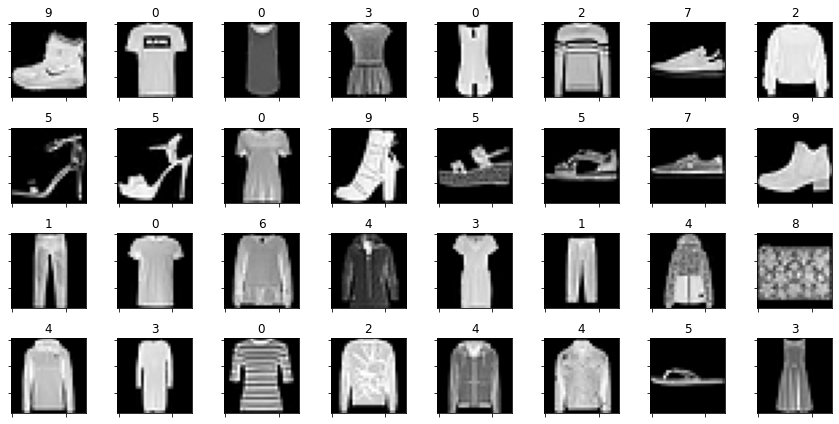

In [ ]:
# Aquí descargamos los datos de FashionMNIST es un dataset default de pytorch se puede ver más aqui:https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = train_set[i]
    images.append(x)
    labels.append(y)
# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


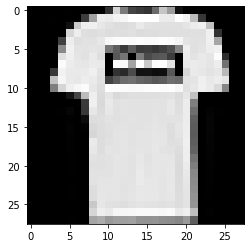

In [ ]:
#Se imprime la forma del data set y un ejemplo
print(train_set)
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

### División de los datos
En la parte anterior del colab ya se cargaron los datos de entranamiento y se guardaron en un conjunto, siendo ya transformados a un tensoe de pytorch por la linea transform. Ahora se descargaran las imágenes y se guardaran las que se utilizarán para poner a prueba la red una vez entrenada. Al ser un conjunto propio de pytorch basta con ponerle a la línea $train$ un valor de $False$ y como se muestra en la graficación de las imágenes corresponden a distintas imagenes a las que están en el test_set.

In [ ]:
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
print(test_set)
print(train_set)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


images[0] shape=torch.Size([1, 28, 28]) dtype=torch.float32


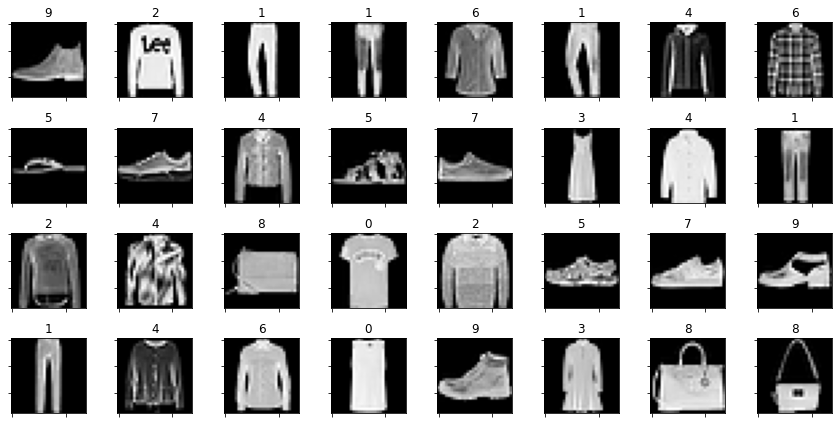

In [ ]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = test_set[i]
    images.append(x)
    labels.append(y)
# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

Ahora vamos a crear un data Loader para acceder más fácil a los datos y también utilizar el batch_size.


In [ ]:
test_dl = DataLoader(
    # subconjunto
    test_set,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)
train_dl = DataLoader(
    # subconjunto
    train_set,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Definción de las arquitecturas a utilizar.
Todas van a recibir algo de tamaño 784 ya que las imágenes se van a aplanar y son de tamaño $28×28=784$. Se utilizaran primeramente dos arquitecturas iguales pero cambiando la función de activación entre ellas emplendo para el primer caso una función ReLU mientras para el segundo caso una función Sigmoide. Al final ambos serán activados por la función Softmax.


### Primer Modelo

In [ ]:
def PrimerModelo():
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,10),
  )
  return model
PrimerModelo()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
summary(PrimerModelo())

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            200,960
├─ReLU: 1-3                              --
├─Linear: 1-4                            2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0

### Segundo Modelo

In [ ]:
def SegundoModelo():
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.Sigmoid(),
    nn.Linear(256,10),
  )
  return model
SegundoModelo()
summary(SegundoModelo())

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            200,960
├─Sigmoid: 1-3                           --
├─Linear: 1-4                            2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0

### Tercer Modelo

In [ ]:
def TercerModelo():
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
  )
  return model
TercerModelo()
summary(TercerModelo())

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            200,960
├─ReLU: 1-3                              --
├─Linear: 1-4                            32,896
├─ReLU: 1-5                              --
├─Linear: 1-6                            8,256
├─ReLU: 1-7                              --
├─Linear: 1-8                            650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0

## Entrenamiento
Vamos a empezar por los primeros dos modelos y ambos con los mismos parámetros.

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=0.1, epochs=50,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

### Pruebas en los modelos





Se utilizó unos parámetros de lr=1e-3, epochs=20 para las siguientes pruebas.

In [ ]:
loss_hist, acc_hist = train(PrimerModelo(), train_dl, test_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[142.93,143.57] acc=[65.76,64.94]
E01 loss=[103.25,104.39] acc=[67.39,66.28]
E02 loss=[ 87.91, 89.32] acc=[69.50,68.33]
E03 loss=[ 79.73, 81.34] acc=[72.25,70.92]
E04 loss=[ 74.30, 75.98] acc=[74.54,73.22]
E05 loss=[ 70.19, 71.91] acc=[76.11,74.87]
E06 loss=[ 67.24, 69.15] acc=[77.22,75.87]
E07 loss=[ 64.45, 66.46] acc=[78.30,77.01]
E08 loss=[ 62.17, 64.18] acc=[79.28,78.09]
E09 loss=[ 60.25, 62.37] acc=[79.99,78.68]
E10 loss=[ 58.59, 60.83] acc=[80.48,79.09]
E11 loss=[ 57.21, 59.47] acc=[80.97,79.53]
E12 loss=[ 55.97, 58.28] acc=[81.31,80.03]
E13 loss=[ 54.93, 57.29] acc=[81.61,80.39]
E14 loss=[ 53.97, 56.49] acc=[81.95,80.74]
E15 loss=[ 53.09, 55.57] acc=[82.22,81.09]
E16 loss=[ 52.36, 54.92] acc=[82.46,81.25]
E17 loss=[ 51.65, 54.36] acc=[82.60,81.40]
E18 loss=[ 51.00, 53.69] acc=[82.87,81.55]
E19 loss=[ 50.44, 53.12] acc=[83.00,81.72]


In [ ]:
loss_hist2, acc_hist2 = train(SegundoModelo(), train_dl, test_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[217.00,217.06] acc=[58.51,57.61]
E01 loss=[200.12,200.23] acc=[59.42,59.19]
E02 loss=[179.97,180.16] acc=[59.24,59.07]
E03 loss=[160.59,160.90] acc=[65.14,64.84]
E04 loss=[144.82,145.24] acc=[65.45,65.04]
E05 loss=[132.48,132.96] acc=[68.25,67.74]
E06 loss=[122.78,123.31] acc=[69.63,69.12]
E07 loss=[114.94,115.57] acc=[69.85,68.96]
E08 loss=[108.48,109.19] acc=[70.69,69.84]
E09 loss=[103.07,103.85] acc=[71.16,70.53]
E10 loss=[ 98.46, 99.27] acc=[71.91,71.09]
E11 loss=[ 94.52, 95.37] acc=[72.33,71.51]
E12 loss=[ 91.08, 91.98] acc=[72.50,71.57]
E13 loss=[ 88.12, 89.09] acc=[72.95,72.19]
E14 loss=[ 85.52, 86.58] acc=[73.26,72.55]
E15 loss=[ 83.22, 84.28] acc=[73.43,72.58]
E16 loss=[ 81.19, 82.21] acc=[73.73,73.11]
E17 loss=[ 79.39, 80.55] acc=[73.83,72.98]
E18 loss=[ 77.77, 78.94] acc=[74.16,73.35]
E19 loss=[ 76.34, 77.56] acc=[74.43,73.80]


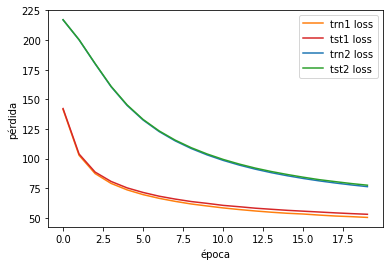

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn1 loss')
plt.plot(tst_loss, 'tab:red', label='tst1 loss')
trn_loss2, tst_loss2 = zip(*loss_hist2)
plt.plot(trn_loss2, 'tab:blue', label='trn2 loss')
plt.plot(tst_loss2, 'tab:green', label='tst2 loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

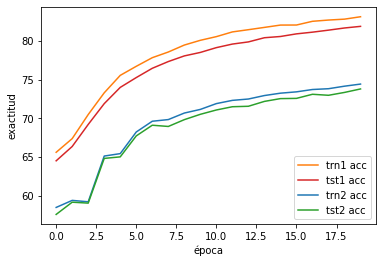

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:orange', label='trn1 acc')
plt.plot(tst_acc, 'tab:red', label='tst1 acc')
trn_loss2, tst_loss2 = zip(*acc_hist2)
plt.plot(trn_loss2, 'tab:blue', label='trn2 acc')
plt.plot(tst_loss2, 'tab:green', label='tst2 acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Ahora usaremos el tercer modelo basado en el primer modelo pero con más capas ocultas.

In [ ]:
loss_hist3, acc_hist3 = train(TercerModelo(), train_dl, test_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[225.10,225.16] acc=[19.45,19.39]
E01 loss=[210.25,210.37] acc=[21.01,20.75]
E02 loss=[163.23,163.58] acc=[38.15,37.84]
E03 loss=[118.43,119.29] acc=[59.70,59.28]
E04 loss=[ 99.17,100.34] acc=[64.72,63.94]
E05 loss=[ 88.82, 90.30] acc=[66.54,65.65]
E06 loss=[ 82.14, 83.74] acc=[70.60,69.59]
E07 loss=[ 77.12, 79.01] acc=[71.95,71.09]
E08 loss=[ 73.40, 75.25] acc=[73.36,72.72]
E09 loss=[ 69.92, 71.90] acc=[74.53,74.09]
E10 loss=[ 67.62, 69.80] acc=[75.56,74.65]
E11 loss=[ 65.32, 67.66] acc=[76.86,75.95]
E12 loss=[ 62.92, 65.21] acc=[77.31,76.51]
E13 loss=[ 61.25, 63.52] acc=[78.11,77.18]
E14 loss=[ 59.92, 62.37] acc=[78.85,77.81]
E15 loss=[ 58.37, 60.80] acc=[79.35,78.29]
E16 loss=[ 57.41, 59.94] acc=[79.98,78.95]
E17 loss=[ 56.61, 59.29] acc=[79.84,78.72]
E18 loss=[ 55.40, 58.20] acc=[80.79,79.75]
E19 loss=[ 54.51, 57.45] acc=[80.91,79.67]


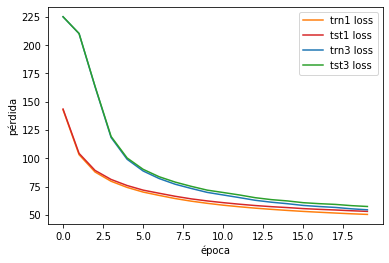

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn1 loss')
plt.plot(tst_loss, 'tab:red', label='tst1 loss')
trn_loss2, tst_loss2 = zip(*loss_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 loss')
plt.plot(tst_loss2, 'tab:green', label='tst3 loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

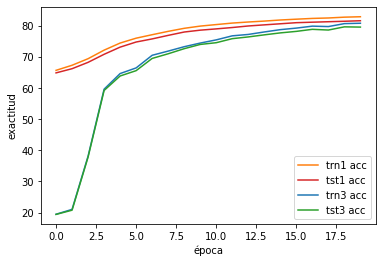

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:orange', label='trn1 acc')
plt.plot(tst_acc, 'tab:red', label='tst1 acc')
trn_loss2, tst_loss2 = zip(*acc_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 acc')
plt.plot(tst_loss2, 'tab:green', label='tst3 acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

En base a estos resultados y a las gráficas presentadas creo que es importante seguir con el tercer modelo pero cambiando los hiperparámetros ya que al final no fue tan distinto el resultado al obtenido con el primer modelo empezando desde mucho más atrás por lo que esto puede indicar que puede mejorar aún mucho más. Esto es sólo una hipótesis mía por lo que se va a cambiar el valor de $\alpha = 0.1$.

In [ ]:
loss_hist3, acc_hist3 = train(TercerModelo(), train_dl, test_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 47.16, 50.61] acc=[82.45,81.73]
E01 loss=[ 36.87, 41.50] acc=[86.37,84.71]
E02 loss=[ 37.07, 42.56] acc=[86.35,84.81]
E03 loss=[ 32.22, 38.13] acc=[87.73,85.67]
E04 loss=[ 29.18, 35.59] acc=[89.23,87.24]
E05 loss=[ 27.10, 34.96] acc=[89.78,87.51]
E06 loss=[ 26.42, 34.94] acc=[90.01,87.48]
E07 loss=[ 25.86, 35.01] acc=[90.08,87.16]
E08 loss=[ 24.62, 34.18] acc=[90.86,88.05]
E09 loss=[ 22.74, 33.02] acc=[91.52,88.22]
E10 loss=[ 25.06, 34.65] acc=[90.93,87.61]
E11 loss=[ 22.25, 33.21] acc=[91.61,88.31]
E12 loss=[ 23.71, 34.59] acc=[90.75,87.46]
E13 loss=[ 20.96, 33.21] acc=[92.22,88.45]
E14 loss=[ 20.17, 33.25] acc=[92.21,88.33]
E15 loss=[ 20.07, 33.04] acc=[92.33,88.38]
E16 loss=[ 23.08, 39.49] acc=[91.37,87.62]
E17 loss=[ 21.19, 37.62] acc=[91.73,87.46]
E18 loss=[ 17.80, 33.12] acc=[93.29,89.05]
E19 loss=[ 17.18, 32.84] acc=[93.50,89.00]


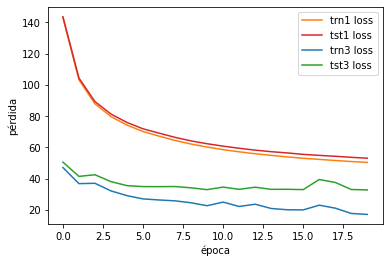

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn1 loss')
plt.plot(tst_loss, 'tab:red', label='tst1 loss')
trn_loss2, tst_loss2 = zip(*loss_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 loss')
plt.plot(tst_loss2, 'tab:green', label='tst3 loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

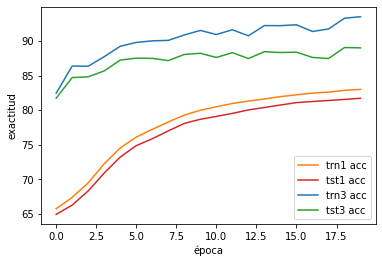

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:orange', label='trn1 acc')
plt.plot(tst_acc, 'tab:red', label='tst1 acc')
trn_loss2, tst_loss2 = zip(*acc_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 acc')
plt.plot(tst_loss2, 'tab:green', label='tst3 acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Se puede observar como el cambio si funcionó demasiado, veamos si para el primer modelo tiene resultados similares.

In [ ]:
loss_hist, acc_hist = train(PrimerModelo(), train_dl, test_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 42.91, 47.19] acc=[84.17,82.36]
E01 loss=[ 37.76, 42.27] acc=[86.08,84.69]
E02 loss=[ 33.95, 39.39] acc=[87.64,85.95]
E03 loss=[ 32.11, 38.40] acc=[88.14,86.07]
E04 loss=[ 30.00, 36.64] acc=[88.81,86.94]
E05 loss=[ 30.35, 37.43] acc=[88.76,86.55]
E06 loss=[ 27.46, 35.22] acc=[89.76,87.28]
E07 loss=[ 26.10, 34.41] acc=[90.60,87.87]
E08 loss=[ 25.92, 34.54] acc=[90.55,87.90]
E09 loss=[ 24.01, 33.10] acc=[91.29,87.78]
E10 loss=[ 22.95, 32.38] acc=[91.68,88.34]
E11 loss=[ 23.07, 33.53] acc=[91.47,88.41]
E12 loss=[ 22.32, 33.07] acc=[91.91,88.23]
E13 loss=[ 21.82, 33.44] acc=[91.91,88.07]
E14 loss=[ 21.96, 33.83] acc=[91.81,88.38]
E15 loss=[ 19.67, 32.04] acc=[92.78,88.77]
E16 loss=[ 20.45, 33.26] acc=[92.36,88.55]
E17 loss=[ 20.64, 33.85] acc=[92.31,88.43]
E18 loss=[ 21.98, 35.75] acc=[91.75,87.29]
E19 loss=[ 19.47, 33.90] acc=[92.67,88.76]


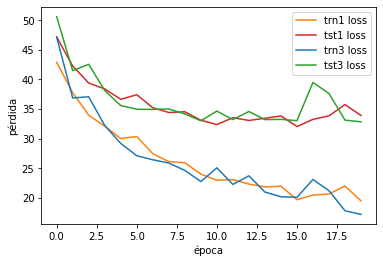

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn1 loss')
plt.plot(tst_loss, 'tab:red', label='tst1 loss')
trn_loss2, tst_loss2 = zip(*loss_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 loss')
plt.plot(tst_loss2, 'tab:green', label='tst3 loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

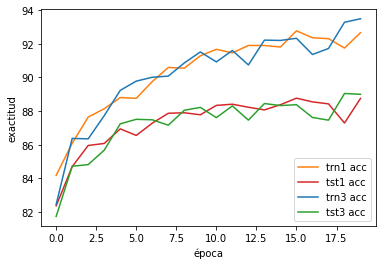

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:orange', label='trn1 acc')
plt.plot(tst_acc, 'tab:red', label='tst1 acc')
trn_loss2, tst_loss2 = zip(*acc_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 acc')
plt.plot(tst_loss2, 'tab:green', label='tst3 acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Ahora vamos a cambiar las épocas a un valor de 50.

In [ ]:
loss_hist, acc_hist = train(PrimerModelo(), train_dl, test_dl)

  0%|          | 0/50 [00:00<?, ?it/s]

E00 loss=[ 42.18, 45.76] acc=[84.90,83.31]
E01 loss=[ 38.54, 43.34] acc=[86.02,84.17]
E02 loss=[ 34.56, 40.25] acc=[87.33,85.51]
E03 loss=[ 31.01, 36.38] acc=[88.98,87.10]
E04 loss=[ 29.66, 35.92] acc=[89.19,86.95]
E05 loss=[ 30.51, 37.70] acc=[88.35,86.28]
E06 loss=[ 27.35, 34.99] acc=[89.80,87.62]
E07 loss=[ 28.53, 36.99] acc=[89.10,86.61]
E08 loss=[ 25.58, 34.39] acc=[90.56,87.79]
E09 loss=[ 26.76, 36.82] acc=[89.96,87.07]
E10 loss=[ 23.60, 33.66] acc=[91.36,88.07]
E11 loss=[ 23.72, 33.89] acc=[91.16,88.14]
E12 loss=[ 24.07, 35.01] acc=[90.90,87.58]
E13 loss=[ 21.42, 32.70] acc=[92.11,88.65]
E14 loss=[ 23.39, 35.57] acc=[91.14,87.12]
E15 loss=[ 21.51, 33.92] acc=[92.01,88.07]
E16 loss=[ 20.18, 33.53] acc=[92.29,88.32]
E17 loss=[ 22.53, 35.20] acc=[91.38,87.30]
E18 loss=[ 20.74, 33.75] acc=[92.28,87.86]
E19 loss=[ 19.22, 33.80] acc=[92.74,88.10]
E20 loss=[ 19.46, 34.27] acc=[92.53,88.11]
E21 loss=[ 17.29, 32.59] acc=[93.57,88.86]
E22 loss=[ 17.47, 33.66] acc=[93.52,88.74]
E23 loss=[ 

In [ ]:
loss_hist3, acc_hist3 = train(TercerModelo(), train_dl, test_dl)

  0%|          | 0/50 [00:00<?, ?it/s]

E00 loss=[ 46.30, 49.73] acc=[82.86,81.26]
E01 loss=[ 39.08, 44.07] acc=[84.98,83.54]
E02 loss=[ 33.47, 39.23] acc=[87.45,85.84]
E03 loss=[ 30.70, 37.09] acc=[88.34,86.42]
E04 loss=[ 27.66, 35.47] acc=[89.73,87.43]
E05 loss=[ 34.73, 43.21] acc=[87.32,85.50]
E06 loss=[ 26.30, 33.91] acc=[89.99,87.48]
E07 loss=[ 26.48, 35.88] acc=[89.92,87.04]
E08 loss=[ 25.22, 34.38] acc=[90.30,87.27]
E09 loss=[ 25.64, 35.59] acc=[90.30,87.19]
E10 loss=[ 23.98, 34.57] acc=[90.86,88.08]
E11 loss=[ 23.92, 34.49] acc=[90.79,87.71]
E12 loss=[ 21.04, 33.50] acc=[91.91,88.58]
E13 loss=[ 27.53, 40.17] acc=[89.33,86.27]
E14 loss=[ 20.71, 34.55] acc=[92.11,88.38]
E15 loss=[ 19.44, 33.46] acc=[92.67,88.77]
E16 loss=[ 18.56, 32.76] acc=[92.84,88.93]
E17 loss=[ 20.50, 35.54] acc=[92.21,88.09]
E18 loss=[ 17.95, 33.70] acc=[93.08,88.98]
E19 loss=[ 17.27, 34.84] acc=[93.47,88.94]
E20 loss=[ 17.56, 33.49] acc=[93.22,88.85]
E21 loss=[ 17.54, 35.61] acc=[93.14,88.68]
E22 loss=[ 18.67, 37.39] acc=[93.01,88.37]
E23 loss=[ 

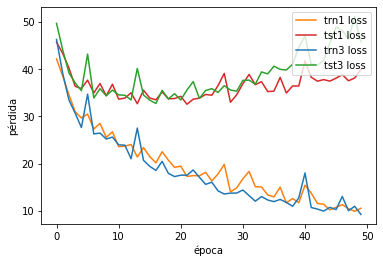

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn1 loss')
plt.plot(tst_loss, 'tab:red', label='tst1 loss')
trn_loss2, tst_loss2 = zip(*loss_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 loss')
plt.plot(tst_loss2, 'tab:green', label='tst3 loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

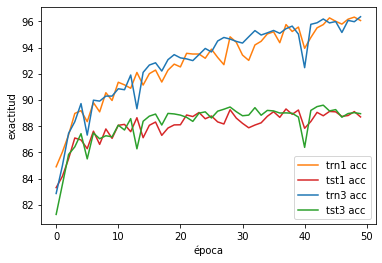

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:orange', label='trn1 acc')
plt.plot(tst_acc, 'tab:red', label='tst1 acc')
trn_loss2, tst_loss2 = zip(*acc_hist3)
plt.plot(trn_loss2, 'tab:blue', label='trn3 acc')
plt.plot(tst_loss2, 'tab:green', label='tst3 acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## Comentarios finales
Cambiar los hiperparámetros son de gran utilidad para tratar de mejorar el módelo; sin embargo, puede que no siempre sea tan obvio como cambiarlos. También el agregar más capas ocultas ayuda al modelo aunque sea un poco como hemos visto en las gráficas pero se debe de tomar a consideración el aumento en parámetros que esto implica donde pasa de $203,530$ a $242,762$ por una ligera mejora. A lo mejor en redes y conjuntos de datos más grandes y complejos esta mejora no valga la pena. También es importante mencionar no casarse con una función de activación yo he de confesar que tenía preferencia por la sigmoide pero en este caso ya se pudo observar como se queda atrás de la ReLu.
